In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import healpy as hp

In [2]:
# File downloaded from https://lambda.gsfc.nasa.gov/product/foreground/fg_ovrolwa_radio_maps_get.html
filepath = "/Users/ruby/Astro/mmode_maps_eastwood/ovro_lwa_sky_map_73.152MHz.fits"

In [3]:
file_contents = fits.open(filepath)

In [4]:
file_contents[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2017-09-22T20:32:50' / file creation date (YYYY-MM-DDThh:mm:ss UT)   

In [5]:
file_contents[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                    8 / width of table in bytes                        
NAXIS2  =             50331648 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    1 / number of fields in each row                   
TTYPE1  = 'SIGNAL  '           / label for field   1                            
TFORM1  = '1D      '           / data format of field: 8-byte DOUBLE            
EXTNAME = 'BINTABLE'           / name of this binary table extension            
PIXTYPE = 'HEALPIX '           / HEALPIX pixelization                           
ORDERING= 'RING    '        

In [6]:
map_data = np.array(file_contents[1].data, dtype=float)

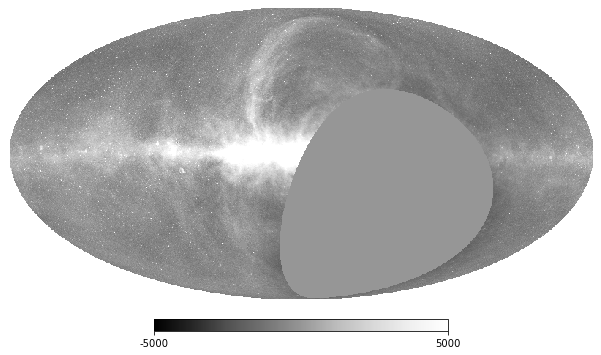

In [7]:
# Plot map in Galactic coordinates
proj = hp.mollview(
    map=map_data,
    coord=file_contents[1].header["COORDSYS"],
    nest=False,
    title="",
    min=-5000,
    max=5000,
    cbar=True,
    cmap='Greys_r',
    return_projected_map=False,
    notext=True,
    unit=None
)
plt.show()


In [8]:
np.max(map_data)

68827.04215134219

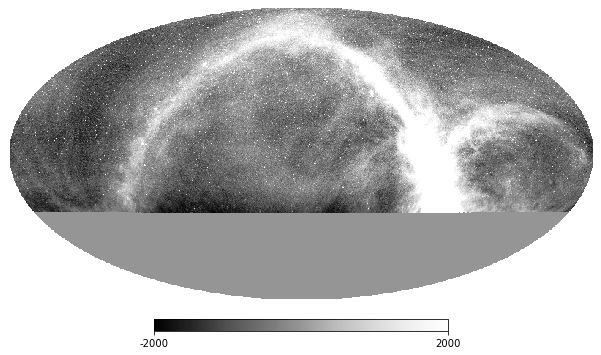

In [9]:
# Plot map in Equitorial coordinates
proj = hp.mollview(
    map=map_data,
    coord=[
        file_contents[1].header["COORDSYS"],
        "C"
    ],
    nest=False,
    title="",
    min=-2000,
    max=2000,
    cbar=True,
    cmap='Greys_r',
    return_projected_map=False,
    notext=True,
    unit=None
)
plt.show()

In [10]:
# Get coordinates of each pixel
nside = file_contents[1].header["NSIDE"]
npix = hp.nside2npix(nside)
theta_gal, phi_gal = hp.pixelfunc.pix2ang(
    nside,
    np.arange(npix),
    nest=False
)
rot = hp.rotator.Rotator(coord=['C', 'G'])
theta_eq, phi_eq = rot(theta_gal, phi_gal)
ra_arr = np.degrees(phi_eq)  # RA values in degrees
ra_arr[np.where(ra_arr < 0)] += 360.  # Make all RA values positive
dec_arr = 90. - np.degrees(theta_eq)  # Dec values in degrees

In [11]:
# Reorder map to equitorial coordinates:
rot_map = hp.get_interp_val(map_data, theta_eq, phi_eq, nest=False)

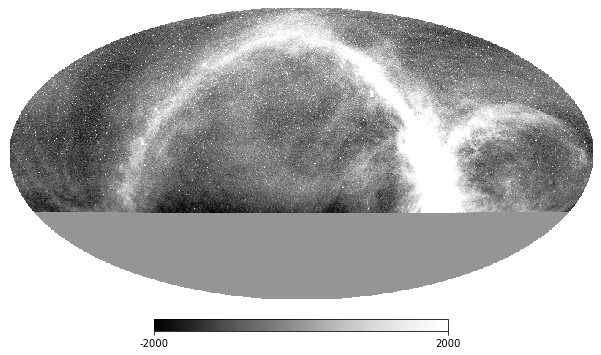

In [12]:
# Plot map in Equitorial coordinates
proj = hp.mollview(
    map=rot_map,
    nest=False,
    title="",
    min=-2000,
    max=2000,
    cbar=True,
    cmap='Greys_r',
    return_projected_map=False,
    notext=True,
    unit=None
)
plt.show()

In [13]:
# Grab a small subset of pixels
use_pixels = np.intersect1d(np.where(np.abs(ra_arr - 50) < 5)[0], np.where(np.abs(dec_arr - 50) < 5)[0])
print(np.shape(use_pixels))

(78315,)


In [14]:
def get_pixel_corners(nside, pixels):
# Function to get the coordinates of the pixel boundary
# Assumes the map is in galactic coordinates

    # Get coordinates
    corner_coords = hp.boundaries(
        nside, pixels, step=1, nest=False
    )

    # Do coordinate transform to RA/Dec
    thetas_gal = np.zeros((len(pixels), 4), dtype=float)
    phis_gal = np.zeros((len(pixels), 4), dtype=float)
    for pixel in range(len(pixels)):
        thetas_gal_pix, phis_gal_pix = hp.pixelfunc.vec2ang(
            np.transpose(corner_coords[pixel]), lonlat=False
        )
        thetas_gal[pixel, :] = thetas_gal_pix
        phis_gal[pixel, :] = phis_gal_pix
    rot = hp.rotator.Rotator(coord=['C', 'G'])
    thetas_eq = np.zeros((len(pixels), 4), dtype=float)
    phis_eq = np.zeros((len(pixels), 4), dtype=float)
    for corner_ind in range(4):
        thetas_eq[:, corner_ind], phis_eq[:, corner_ind] = rot(
            thetas_gal[:, corner_ind], phis_gal[:, corner_ind]
        )
    ras = phis_eq * 180 / np.pi
    decs = 90. - thetas_eq * 180 / np.pi
    
    # It is important to make sure each pixel's coordinates do not span the RA branch cut
    for pixel in range(len(pixels)):
        where_separated = np.where(ras[pixel, :] - np.min(ras[pixel, :]) > 180.0)
    if len(where_separated[0]) > 0:
        ras[pixel, where_separated] = ras[pixel, where_separated] - 360.0

    return ras, decs

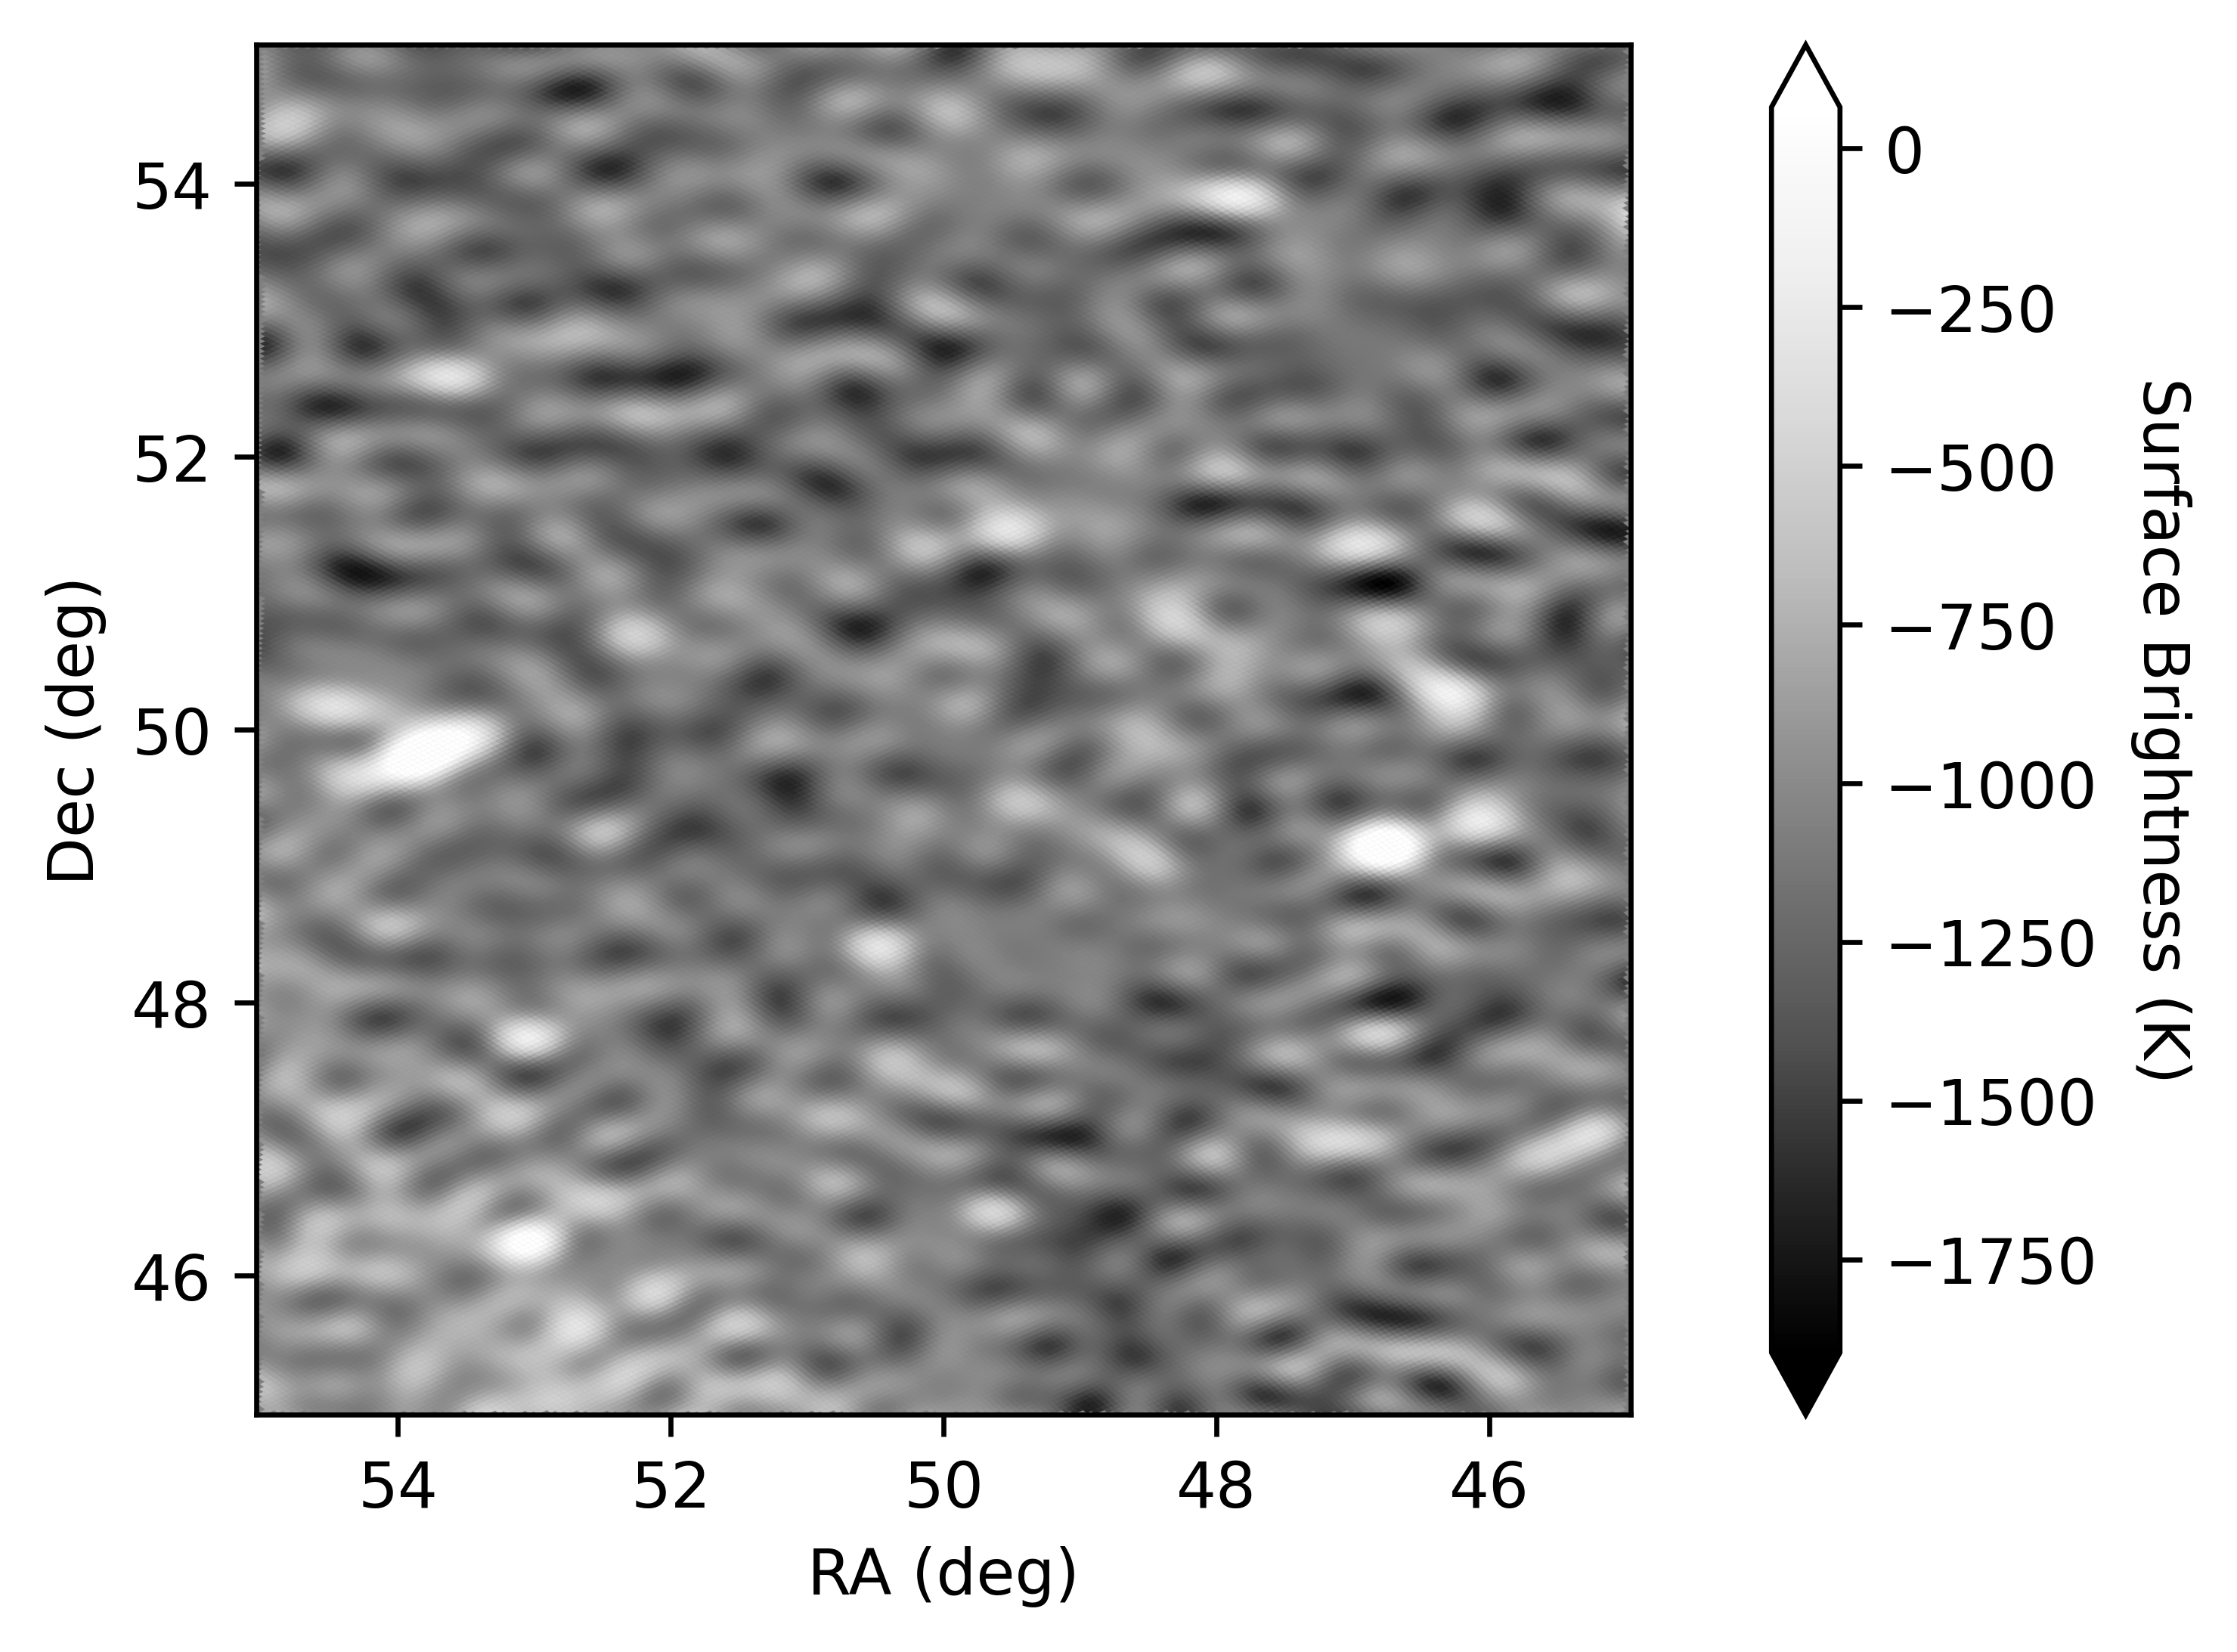

In [15]:
pixel_corner_ras, pixel_corner_decs = get_pixel_corners(nside, use_pixels)

patches = np.zeros(len(use_pixels), dtype=object)
for ind in range(len(use_pixels)):
    polygon = Polygon(np.stack(
        [pixel_corner_ras[ind, :], pixel_corner_decs[ind, :]], axis=1,
    ))
    patches[ind] = polygon
signal_vals = map_data[use_pixels]

cm_use = "Greys_r"
collection = PatchCollection(patches, cmap=cm_use, lw=0.05)
collection.set_array(np.array(signal_vals))  # set the data colors
collection.set_edgecolor("face")  # make the face and edge colors match

collection.set_clim(
    vmin=np.max([np.min(signal_vals), np.mean(signal_vals) - 5 * np.std(signal_vals)]),
    vmax=np.min([np.max(signal_vals), np.mean(signal_vals) + 5 * np.std(signal_vals)]),
)

plt.rcParams["axes.facecolor"] = "gray" # Make regions of missing data grey

# Plot data
fig, ax = plt.subplots(figsize=(8, 4), dpi=600)
ax.add_collection(collection)

plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.axis([
    np.max(pixel_corner_ras), # Increase RA to the left
    np.min(pixel_corner_ras),
    np.min(pixel_corner_decs),
    np.max(pixel_corner_decs),
])
ax.set_aspect(1.)

# Draw colorbar
cbar = fig.colorbar(collection, ax=ax, extend="both")  # add colorbar
cbar.ax.set_ylabel("Surface Brightness (K)", rotation=270, labelpad=15)

plt.show()